<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML2/blob/main/WaveNet/LorenzMap_Wavenet_Univari%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

# Initialisation TPU

In [7]:
import os

use_tpu = True

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TPU_ADDRESS = ''

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.82.217.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.82.217.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


# Chargement des données

In [8]:
# Récupération des données au format .csv
!rm *.csv
!wget --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/LorenzMap.csv"

--2021-08-16 15:10:56--  https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/LorenzMap.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34567 (34K) [text/plain]
Saving to: ‘LorenzMap.csv’

LorenzMap.csv       100%[===================>]  33.76K  --.-KB/s    in 0.002s  

2021-08-16 15:10:57 (14.3 MB/s) - ‘LorenzMap.csv’ saved [34567/34567]



Charge la série sous Pandas et affiche les informations du fichier :

In [9]:
# Création de la série sous Pandas
serie = pd.read_csv("LorenzMap.csv", names=['X','Y','Z'])
serie

,X,Y,Z
0,0.000000,1.00000,1.0500
1,0.048931,0.99832,1.0362
2,0.095542,1.00310,1.0227
3,0.140250,1.01400,1.0097
4,0.183460,1.03090,0.9971
...,...,...,...
1552,1.282300,-1.93910,25.2700
1553,0.901650,-1.87140,24.4010
1554,0.574140,-1.81070,23.5710
1555,0.292540,-1.76190,22.7750


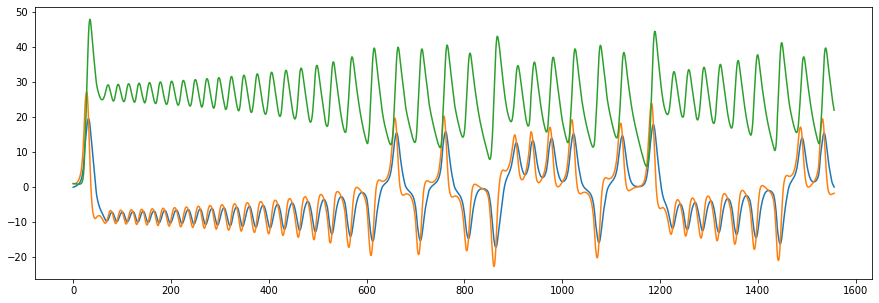

In [10]:
# Affiche la série
plt.figure(figsize=(15,5))
plt.plot(serie.index, serie['X'],serie['Y'])
plt.plot(serie.index, serie['Z'])


In [11]:
serie.dtypes

X    float64
Y    float64
Z    float64
dtype: object

In [12]:
serie = serie.astype(dtype='float32')
serie.dtypes

X    float32
Y    float32
Z    float32
dtype: object

# Séparation des données de test et d'entrainement

In [30]:
serie_entrainement_X = np.array(serie.values[:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))

Taille de l'entrainement : 1557


**Normalisation des données :**

On normalise les données à l'aide de la fonction [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [31]:
from sklearn import preprocessing

# Constrution des séries
serie_entrainement_X_norm = []


for i in range(0,len(serie.columns)):
  serie_entrainement_X_norm.append(serie_entrainement_X[:,i])


serie_entrainement_X_norm = tf.convert_to_tensor(serie_entrainement_X_norm)
serie_entrainement_X_norm = tf.transpose(serie_entrainement_X_norm)

# Initialisaton du MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(serie_entrainement_X_norm)

# Normalisation des séries
serie_entrainement_X_norm = min_max_scaler.transform(serie_entrainement_X_norm)


In [32]:
print(serie_entrainement_X_norm.shape)


(1557, 3)


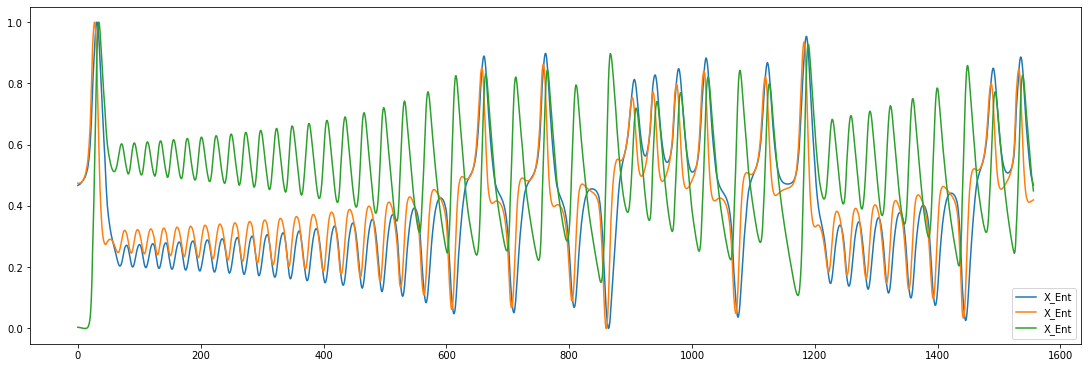

In [35]:
# Affiche quelques séries
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(serie.index[:].values,serie_entrainement_X_norm[:,0:3], label="X_Ent")

ax.legend()
plt.show()

# Création des datasets

In [36]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT)}
# Y = YT+1

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie+1, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie+1))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-1:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

In [37]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 128
longueur_sequence = 1000
longueur_sortie = 1
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm[:,0:-1],serie_entrainement_X_norm[:,-1:], longueur_sequence,longueur_sortie,batch_size,shift)

In [38]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # (Y1,Y2,...,YT)
  print(element[1].shape)               # YT+1

4
(128, 1000, 2)
(128, 1000, 1)
(128, 1, 1)


**3. Préparation des X/Y**

In [40]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_train = [X1,X2]
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_train[0].shape)
print(x_train[1].shape)
print(y_train.shape)


(512, 1000, 2)
(512, 1000, 1)
(512, 1, 1)


# Création du modèle type Wavenet Multivarié - Apprentissage univarié

**1. Création du réseau**

In [ ]:
from keras.layers import Conv1D
from keras.layers import Conv1D
from keras.utils.conv_utils import conv_output_length
from keras import layers
from keras.regularizers import l2
import keras.backend as K
#from keras.engine import Input
#from keras.engine import Model

In [ ]:
class CausalDilatedConv1D(Conv1D):
    def __init__(self, nb_filter, filter_length, init='glorot_uniform', activation=None, weights=None,
                 border_mode='valid', subsample_length=1, atrous_rate=1, W_regularizer=None, b_regularizer=None,
                 activity_regularizer=None, W_constraint=None, b_constraint=None, bias=True, causal=False, **kwargs):
        super(CausalDilatedConv1D, self).__init__(nb_filter, filter_length, weights=weights, activation=activation, 
                padding=border_mode, strides=subsample_length, dilation_rate=atrous_rate, kernel_regularizer=W_regularizer, 
                bias_regularizer=b_regularizer, activity_regularizer=activity_regularizer, kernel_constraint=W_constraint, 
                bias_constraint=b_constraint, use_bias=bias, **kwargs)
        self.causal = causal
        self.nb_filter = nb_filter
        self.atrous_rate = atrous_rate
        self.filter_length = filter_length
        self.subsample_length = subsample_length
        self.border_mode = border_mode
        if self.causal and border_mode != 'valid':
            raise ValueError("Causal mode dictates border_mode=valid.")

    def compute_output_shape(self, input_shape):
        input_length = input_shape[1]
        if self.causal:
            input_length += self.atrous_rate * (self.filter_length - 1)
        length = conv_output_length(input_length, self.filter_length, self.border_mode, self.strides[0], dilation=self.atrous_rate)
        return (input_shape[0], length, self.nb_filter)

    def call(self, x, mask=None):
        if self.causal:
            x = K.temporal_padding(x, padding=(self.atrous_rate * (self.filter_length - 1), 0))
        # return super(CausalAtrousConvolution1D, self).call(x, mask)
        return super(CausalDilatedConv1D, self).call(x)

In [ ]:
def _compute_receptive_field(dilation_depth, stacks):
  return stacks * (2 ** dilation_depth * 2) - (stacks - 1)

In [ ]:
def build_model_residual_block(x, i, s,nb_filters, dim_filters, use_bias,res_l2):
        original_x = x
        relu_out = CausalDilatedConv1D(nb_filters, dim_filters, atrous_rate=2 ** i, border_mode='valid', causal=True, bias=True, name='dilated_conv_%d_relu_s%d' % (2 ** i, s), activation='relu', W_regularizer=l2(res_l2))(x)
        res_x = layers.Conv1D(1, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        skip_x = layers.Conv1D(1, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        res_x = layers.Add()([original_x, res_x])
        return res_x, skip_x

def build_model_couche_condition(x, nb_input_bins, nb_filters, dim_filters, use_bias,res_l2):
        original_x = x
        skip_conditions = []

        relu_out = CausalDilatedConv1D(nb_filters, dim_filters, atrous_rate=1, border_mode='valid', causal=True, bias=True, name='dilated_conv_%d_condition_%d_s%d' % (1,1, 0), activation='relu',
                                       W_regularizer=l2(res_l2))(tf.expand_dims(x[:,:,0],2))

        skip_ = layers.Conv1D(1, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        skip_conditions.append(skip_)

        for i in range(1,nb_input_bins):
          relu_out = CausalDilatedConv1D(nb_filters, dim_filters, atrous_rate=1, border_mode='valid', causal=True, bias=True, name='dilated_conv_%d_condition_%d_s%d' % (1,i+1,0), activation='relu',
                                                    W_regularizer=l2(res_l2))(tf.expand_dims(x[:,:,i],2))

          skip_ = layers.Conv1D(1, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
          skip_conditions.append(skip_)

        out = layers.Add()(skip_conditions)
        return out


def build_model(fragment_length, nb_filters, dim_filters, nb_input_bins, dilation_depth, stacks, use_bias, res_l2, final_l2):
        input_shape = tf.keras.Input(shape=(fragment_length, nb_input_bins), name='input_part')
        out = input_shape

        for s in range(stacks):
            if nb_input_bins > 1 :
                # Couche conditionnée
                out = build_model_couche_condition(out, nb_input_bins, nb_filters, dim_filters, use_bias, res_l2)
            else:
                out, skip_out = build_model_residual_block(out, 0, s , nb_filters, dim_filters, use_bias, res_l2)

            # Couches intermédiaires
            for i in range(1, dilation_depth + 1):
                out, skip_out = build_model_residual_block(out, i, s, nb_filters, dim_filters, use_bias, res_l2)

        # Couche de sortie
        out = layers.Activation('linear', name="output_linear")(out)
        out = layers.Conv1D(1, 1, padding='same', kernel_regularizer=l2(final_l2))(out)
        model = tf.keras.Model(input_shape, out)
        return model


**2. Construction du modèle**

In [ ]:
def compute_receptive_field_(dilation_depth, nb_stacks):
    receptive_field = nb_stacks * (2 ** dilation_depth * 2) - (nb_stacks - 1)
    return receptive_field

nb_filters = 2
dim_filters = 2
nb_input_bins = 1
dilation_depth = 3
nb_stacks = 1
use_bias = False
res_l2 = 0
final_l2 = 0

fragment_length = compute_receptive_field_(dilation_depth, nb_stacks)
fragment_length

model = build_model(fragment_length, nb_filters, dim_filters, nb_input_bins, dilation_depth, nb_stacks, use_bias, res_l2, final_l2)
model.summary()

**2. Optimisation de l'apprentissage**

Pour accélérer le traitement des données, nous n'allons pas utiliser l'intégralité des données pendant la mise à jour du gradient, comme cela a été fait jusqu'à présent (en utilisant le dataset).  
Cette fois-ci, nous allons forcer les mises à jour du gradient à se produire de manière moins fréquente en attribuant la valeur du batch_size à prendre en compte lors de la regression du modèle.  
Pour cela, on utilise l'argument "batch_size" dans la méthode fit. En précisant un batch_size=1000, cela signifie que :
 - Sur notre total de 56000 échantillons, 56 seront utilisés pour les calculs du gradient
 - Il y aura également 56 itérations à chaque période.
  
    
    
Si nous avions pris le dataset comme entrée, nous aurions eu :
- Un total de 56000 échantillons également
- Chaque période aurait également pris 56 itérations pour se compléter
- Mais 1000 échantillons auraient été utilisés pour le calcul du gradient, au lieu de 56 avec la méthode utilisée.

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

def  My_MSE(y_true,y_pred):
  return(tf.keras.metrics.mse(y_true,y_pred)*std.numpy()+mean.numpy())

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics=["mse",My_MSE])

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint],batch_size=batch_size)

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [ ]:
max_periodes = 1000

# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

def  My_MSE(y_true,y_pred):
  return(tf.keras.metrics.mse(y_true,y_pred)*std.numpy()+mean.numpy())
  
# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=10,
    decay_rate=0)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics=["mse",My_MSE])

# Entraine le modèle, avec une réduction des calculs du gradient
if nb_input_bins == 1:
  historique = model.fit(x=tf.expand_dims(x_train[:,:,0],2),y=y_train,validation_data=(tf.expand_dims(x_val[:,:,0],2),y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-6,periodes = 50, term="loss")],batch_size=batch_size)
else:
  historique = model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-5,periodes = 10, term="My_MSE")],batch_size=batch_size)


# Entraine le modèle sans réduction de calculs
#historique = model.fit(dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-8,periodes = 10, term="val_My_MSE")])


In [ ]:
model.load_weights("poids_train.hdf5")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**3. Prédictions single step**

In [ ]:
# Création des instants d'entrainement et de validation
y_train_timing = serie_etude.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_train)]
y_val_timing = serie_etude.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_val)]

# Calcul des prédictions
if nb_input_bins == 1:
  pred_ent = model.predict(tf.expand_dims(x_train[:,:,0],2), verbose=1)
  pred_val = model.predict(tf.expand_dims(x_val[:,:,0],2), verbose=1)
else:
  pred_ent = model.predict(x_train, verbose=1)
  pred_val = model.predict(x_val, verbose=1)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=serie_etude.index,y=serie_entrainement[0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=serie_etude.index[temps_separation:],y=serie_test[0],line=dict(color='blue', width=1)))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=serie_etude.index[taille_fenetre+horizon-1:],y=pred_ent[:,taille_fenetre-1,0],line=dict(color='green', width=1)))

# Courbes des prédictions de validations
fig.add_trace(go.Scatter(x=serie_etude.index[temps_separation+taille_fenetre+horizon-1:],y=pred_val[:,taille_fenetre-1,0],line=dict(color='red', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Prédictions multi-step ahead**

In [ ]:
predictions = []

data_to_predict = x_val[0,:,0]
data_to_predict = tf.expand_dims(data_to_predict,1)
data_to_predict = tf.expand_dims(data_to_predict,0)

prediction = model.predict(data_to_predict)
predictions.append(prediction[0,taille_fenetre-1,0])

data_to_predict = x_val[1,0:taille_fenetre-1,0]
data_to_predict = np.insert(data_to_predict,taille_fenetre-1,predictions[0])

#for t in y_val_timing:
for i in range(1,200):
  data_to_predict = tf.expand_dims(data_to_predict,1)
  data_to_predict = tf.expand_dims(data_to_predict,0)
  prediction = model.predict(data_to_predict,1)
  predictions.append(prediction[0,taille_fenetre-1,0])

  data_to_predict = x_val[i+1,0:taille_fenetre-1,0]
  data_to_predict = np.insert(data_to_predict,taille_fenetre-1,predictions[i])


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

n_max = len(predictions)

# Courbes originales
fig.add_trace(go.Scatter(x=serie_etude.index,y=serie_entrainement[0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=serie_etude.index[temps_separation:],y=serie_test[0],line=dict(color='blue', width=1)))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=serie_etude.index[taille_fenetre+horizon-1:],y=pred_ent[:,taille_fenetre-1,0],line=dict(color='green', width=1)))

# Courbes des prédictions de validations
fig.add_trace(go.Scatter(x=serie_etude.index[temps_separation+taille_fenetre+horizon-1:temps_separation+taille_fenetre+horizon-1+n_max],y=predictions[0:n_max],line=dict(color='red', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()